# ◇ 라이브러리 설정 MNIST, numpy

In [134]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from collections import OrderedDict

# ◇ 계층 클래스 Affine
#### Affine클래스는 해당 부분을 저장
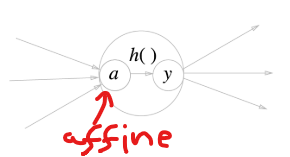

In [135]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x, flg):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        #print(self.x.shape, self.W.shape)
        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

# ◇ 활성화 함수 Relu, softmax
# ◇ 손실 함수 cross_entropy_error (교차 엔트로피 오차)
# ◇ 수치미분-기울기 numerical_gradient
# ◇ 출력층 클래스 -> 소프트맥스, 손실 함수 값을 계산-저장 SoftmaxWithLoss

----
#### class Relu는 해당 부분을 저장
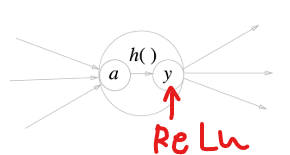

In [136]:
# Relu 활성화 함수 순전파, 역전파를 저장하는 클래스
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x, flg):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [137]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [138]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [139]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

In [140]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

# ◇ 최적화 함수 SGD, Momentum, AdaGrad

In [141]:
class SGD:
    def __init__(self, Ir=0.01):
        self.Ir =Ir

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.Ir * grads[key]

In [142]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

In [143]:
class AdaGrad:
    def __init__ (self, Ir=0.01):
        self.Ir =Ir
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys() :
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.Ir * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


# ◇ 학습 자료에 있는 배치 정규화 코드

In [144]:
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma=1, beta=0, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

# ◇ 가중치 초기화 He

In [145]:
def He_init(input, ouput):
    return np.sqrt(2.0 / input) * np.random.randn(input, ouput)

# ◇ 다층 신경망 클래스

In [150]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.maxIndex = len(hidden_size)
        print("\n\n신경망 학습 시작 - 신경망: %d층"%(self.maxIndex+1))
        
        self.params = {}        
        self.params['W1'] = He_init(input_size, hidden_size[0])
        self.params['b1'] = np.zeros(hidden_size[0])

        #print(self.params['W1'].shape)

        for i in range(1, self.maxIndex):
            self.params['W' + str(i+1)] = He_init(hidden_size[i-1], hidden_size[i]) 
            self.params['b' + str(i+1)] = np.zeros(hidden_size[i])
            #print(self.params['W'  + str(i+1)].shape)

        self.params['W' + str(self.maxIndex)] = He_init(hidden_size[self.maxIndex - 1], output_size) 
        self.params['b' + str(self.maxIndex)] = np.zeros(output_size)
        #print(self.params['W' + str(self.maxIndex)].shape)

        # 계층 생성
        self.layers = OrderedDict()
        
        for i in range(1, self.maxIndex):
            self.layers['Affine' + str(i)] = Affine(self.params['W' + str(i)], self.params['b' + str(i)])
            self.layers['BatchNormalization' + str(i)] = BatchNormalization()
            self.layers['Relu' + str(i)] = Relu()
    
        self.layers['Affine' + str(self.maxIndex)] = Affine(self.params['W' + str(self.maxIndex)], self.params['b' + str(self.maxIndex)])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x, train_flg=True):
        for layer in self.layers.values():
            x = layer.forward(x, train_flg)
        return x
        
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x, False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}

        for i in range(1, self.maxIndex+1):
            grads['W' + str(i)] = numerical_gradient(loss_W, self.params['W' + str(i)])
            grads['b' + str(i)] = numerical_gradient(loss_W, self.params['b' + str(i)])

        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)

        # 계층 레이어의 값을 리스트로 변환하여 가져옴 -> 해당 리스트를 거꾸로 정렬 -> 순서대로 계층의 역전파를 실행
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 기울기
        grads = {}
        for i in range(1, self.maxIndex+1):
            grads['W' + str(i)], grads['b' + str(i)] = self.layers['Affine' + str(i)].dW, self.layers['Affine' + str(i)].db
        
        return grads


# ◇ MNIST 불러오기

In [147]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

----
# 과제) 신경망 학습 코드 작성 시 발생한 문제와 해결 내용
<br/>

### 1) 기존 가중치 업데이트 방식 가중치 - (학습률*기울기) / 해당 방법으로 업데이트 시 학습이 잘 안됨
#### &emsp;&emsp;&emsp;--> 해결방법 : SGD, 모멘텀, AdaGrad를 사용해서 적절한 기울기 업데이트 방법을 사용하니 학습이 잘되는 것을 확인
<br/>

### 2) 2층 신경망에서는 학습에 문제가 없었으나 4층으로 늘릴 시 학습이 안되는 문제가 발생
#### &emsp;&emsp;&emsp;--> 해결방법 : 초기화 방법을 변경 / ReLu함수의 가중치 초기화를  He초기화(He_init 함수)로 하니 정상적으로 학습이 가능함
#### &emsp;&emsp;&emsp;&emsp;&emsp; 이후 층을 늘려도 학습이 되는 것을 확인
<br/>

### 3) 초기값, 모멘텀, SGD 등을 통해 어느정도 학습은 가능하나 일정 수준 이상으로 학습이 되지 않음
#### &emsp;&emsp;&emsp;--> 해결방법 : 교제에 나온 배치치 정규화를 시도
<br/>


# ◇ 학습 알고리즘 
<br />

## 계산 과정
1. TwoLayerNet클래스로 가중치 초기화 밑 신경망 구조를 설정 (hidden_size을 리스트로 보내어 좀 더 간단하게 층과 노드를 설정)
2. 횟수는 1만번 진행하며, 하이퍼피라미터를 수정
3. 배치 사이즈만큼 학습, 시험 데이터를 TwoLayerNet.gradient 으로 보내어 기울기를 구한다
- - 1. loss함수에서 predict함수를 호출하여 순전파를 진행한다 (OrderedDict으로 순서가 있는 딕셔너리를 통해 입력층부터 계산)
    2. predict함수는 출력층 전까지 값을 리턴한 후 loss함수에서 SoftmaxWithLoss클래스에 소프트맥스값, 교차 엔트로피 오차(손실)값을 설정한다.
    3. 2번에서 설정한 SoftmaxWithLoss클래스를 역전파를 하고, OrderedDict를 리스트로 변환하여 거꾸로 정렬, 순서대로 Affine, ReLu클래스의 역전파를 실행
    4. 역전파를 통해 각 Affine클래스에 저장된 dw, db값을 grads에 저장한 후 리턴
4. 구한 기울기를 SGD, Momentum, AdaGrad 중 1개를 이용하여 기존 기울기에 업데이트를 진행

## 하이퍼피라미터
- #### iters_num : 반복 횟수 = **10,000 고정**
- #### batch_size : 배치 사이즈 = **100~300?**
- #### hidden_size : 은닉층 노드 수 = **5 ~ 15**
- #### learning_rate : 학습률 = **0.001 ~ 0.019**

In [148]:
iters_num = 10000
batch_size = 100
#hidden_size = 15 
hidden_size = [15, 15, 15]
learning_rate = 0.011

# 기울기 최적화 함수들
sgd = SGD()
momentum = Momentum()
adaGrad = AdaGrad()

train_loss_list = []
train_acc_list = []
test_acc_list = []

train_size = x_train.shape[0]
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=hidden_size, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식
    
    # 일반 갱신
    #for key in ('W1', 'b1', 'W2', 'b2'): network.params[key] -= learning_rate * grad[key]
        
    # SGD 학습, 모멘텀 학습, AdaGrad 학습
    #sgd.update(network.params, grad)
    momentum.update(network.params, grad)
    #adaGrad.update(network.params, grad)
    
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("%2d 번째 학습(에폭) --> train_acc : %.2f%%, test_acc : %.2f%%" % (len(train_acc_list), train_acc*100, test_acc*100))

신경망 학습 시작 - 신경망: 4층
 1 번째 학습(에폭) --> train_acc : 9.79%, test_acc : 9.89%
 2 번째 학습(에폭) --> train_acc : 91.30%, test_acc : 91.73%
 3 번째 학습(에폭) --> train_acc : 92.83%, test_acc : 92.65%
 4 번째 학습(에폭) --> train_acc : 93.78%, test_acc : 93.62%
 5 번째 학습(에폭) --> train_acc : 94.40%, test_acc : 93.77%
 6 번째 학습(에폭) --> train_acc : 94.95%, test_acc : 94.61%
 7 번째 학습(에폭) --> train_acc : 94.95%, test_acc : 94.21%
 8 번째 학습(에폭) --> train_acc : 95.46%, test_acc : 94.67%
 9 번째 학습(에폭) --> train_acc : 95.64%, test_acc : 95.02%
10 번째 학습(에폭) --> train_acc : 95.82%, test_acc : 94.93%
11 번째 학습(에폭) --> train_acc : 95.84%, test_acc : 95.05%
12 번째 학습(에폭) --> train_acc : 96.03%, test_acc : 95.08%
13 번째 학습(에폭) --> train_acc : 96.15%, test_acc : 95.24%
14 번째 학습(에폭) --> train_acc : 96.27%, test_acc : 95.30%
15 번째 학습(에폭) --> train_acc : 96.32%, test_acc : 95.36%
16 번째 학습(에폭) --> train_acc : 96.48%, test_acc : 95.22%
17 번째 학습(에폭) --> train_acc : 96.59%, test_acc : 95.55%


----

In [151]:
import optuna
import numpy as np

# 기울기 최적화 함수들

# 하이퍼파라미터 범위 설정
learning_rate_range = [0.001, 0.019]
num_layers_range = (3, 6)
iters_num_range = (10000, 10000)  # Fixed iterations (can be removed for further tuning)
batch_size_range = (100, 300)

def objective(trial):
    # 하이퍼파라미터 설정
    learning_rate = trial.suggest_float("learning_rate", learning_rate_range[0], learning_rate_range[1])
    #hidden_size = [trial.suggest_int("hidden_size_{}".format(i), hidden_size_range[i][0], hidden_size_range[i][1]) for i in range(len(hidden_size_range))]
    num_layers = trial.suggest_int("num_layers", num_layers_range[0], num_layers_range[1])
    hidden_size = [15] * num_layers
    iters_num = trial.suggest_int("iters_num", iters_num_range[0], iters_num_range[1])
    batch_size = trial.suggest_int("batch_size", batch_size_range[0], batch_size_range[1])

    # 모델 생성
    network = TwoLayerNet(input_size=784, hidden_size=hidden_size, output_size=10)

    # 최적화 알고리즘 설정
    #optimizer = Momentum()  # SGD, Momentum, AdaGrad 등 사용 가능
    sgd = SGD()
    momentum = Momentum()
    adaGrad = AdaGrad()

    
    # 학습 및 평가
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    train_size = x_train.shape[0]
    iter_per_epoch = max(train_size // batch_size, 1)

    print("learning_rate:", learning_rate)
    print("hidden_size:", hidden_size)
    #print("iters_num:", iters_num)
    print("batch_size:", batch_size)
    
    for i in range(iters_num):
        # 배치 데이터 추출
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        # 오차역전파법으로 기울기 계산
        grad = network.gradient(x_batch, t_batch)

        # SGD 학습, 모멘텀 학습, AdaGrad 학습
        #sgd.update(network.params, grad)
        #momentum.update(network.params, grad)
        adaGrad.update(network.params, grad)

        # 손실 계산
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        # 에포크 마다 평가
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            #print("%2d 번째 학습(에폭) --> train_acc : %.2f%%, test_acc : %.2f%%" % (len(train_acc_list), train_acc*100, test_acc*100))
    print("(에폭) --> train_acc : %.2f%%, test_acc : %.2f%%" % (train_acc_list[-1]*100, test_acc_list[-1]*100))
    # 테스트 정확도 반환
    
    return test_acc_list[-1]  # 마지막 에포크의 테스트 정확도 사용


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)  # 100번의 튜닝 수행

best_params = study.best_params
print("최적의 하이퍼파라미터:")
print("learning_rate:", best_params["learning_rate"])
print("hidden_size:", best_params["num_layers"])
print("최고의 테스트 정확도:", study.best_value)


[I 2024-05-11 18:45:25,252] A new study created in memory with name: no-name-5745871f-e9b3-4ff0-bc1c-972a7d120bf5




신경망 학습 시작 - 신경망: 5층
learning_rate: 0.006426299155908802
hidden_size: [15, 15, 15, 15]
batch_size: 277


[I 2024-05-11 18:46:09,888] Trial 0 finished with value: 0.9492 and parameters: {'learning_rate': 0.006426299155908802, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 277}. Best is trial 0 with value: 0.9492.


(에폭) --> train_acc : 96.37%, test_acc : 94.92%


신경망 학습 시작 - 신경망: 4층
learning_rate: 0.004678349045190709
hidden_size: [15, 15, 15]
batch_size: 106


[I 2024-05-11 18:46:21,411] Trial 1 finished with value: 0.9427 and parameters: {'learning_rate': 0.004678349045190709, 'num_layers': 3, 'iters_num': 10000, 'batch_size': 106}. Best is trial 0 with value: 0.9492.


(에폭) --> train_acc : 94.96%, test_acc : 94.27%


신경망 학습 시작 - 신경망: 6층
learning_rate: 0.0053588095064247615
hidden_size: [15, 15, 15, 15, 15]
batch_size: 174


[I 2024-05-11 18:46:53,568] Trial 2 finished with value: 0.9499 and parameters: {'learning_rate': 0.0053588095064247615, 'num_layers': 5, 'iters_num': 10000, 'batch_size': 174}. Best is trial 2 with value: 0.9499.


(에폭) --> train_acc : 96.07%, test_acc : 94.99%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.016990431271023645
hidden_size: [15, 15, 15, 15]
batch_size: 124


[I 2024-05-11 18:47:08,880] Trial 3 finished with value: 0.9437 and parameters: {'learning_rate': 0.016990431271023645, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 124}. Best is trial 2 with value: 0.9499.


(에폭) --> train_acc : 95.41%, test_acc : 94.37%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.012043323985586454
hidden_size: [15, 15, 15, 15]
batch_size: 203


[I 2024-05-11 18:47:41,989] Trial 4 finished with value: 0.9465 and parameters: {'learning_rate': 0.012043323985586454, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 203}. Best is trial 2 with value: 0.9499.


(에폭) --> train_acc : 95.74%, test_acc : 94.65%


신경망 학습 시작 - 신경망: 6층
learning_rate: 0.008318704223403
hidden_size: [15, 15, 15, 15, 15]
batch_size: 267


[I 2024-05-11 18:48:27,209] Trial 5 finished with value: 0.9493 and parameters: {'learning_rate': 0.008318704223403, 'num_layers': 5, 'iters_num': 10000, 'batch_size': 267}. Best is trial 2 with value: 0.9499.


(에폭) --> train_acc : 96.61%, test_acc : 94.93%


신경망 학습 시작 - 신경망: 7층
learning_rate: 0.004740137950098687
hidden_size: [15, 15, 15, 15, 15, 15]
batch_size: 110


[I 2024-05-11 18:48:46,207] Trial 6 finished with value: 0.9509 and parameters: {'learning_rate': 0.004740137950098687, 'num_layers': 6, 'iters_num': 10000, 'batch_size': 110}. Best is trial 6 with value: 0.9509.


(에폭) --> train_acc : 96.01%, test_acc : 95.09%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.01700453235937839
hidden_size: [15, 15, 15, 15]
batch_size: 268


[I 2024-05-11 18:49:27,536] Trial 7 finished with value: 0.9508 and parameters: {'learning_rate': 0.01700453235937839, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 268}. Best is trial 6 with value: 0.9509.


(에폭) --> train_acc : 96.51%, test_acc : 95.08%


신경망 학습 시작 - 신경망: 7층
learning_rate: 0.017854568692969662
hidden_size: [15, 15, 15, 15, 15, 15]
batch_size: 173


[I 2024-05-11 18:50:02,311] Trial 8 finished with value: 0.9445 and parameters: {'learning_rate': 0.017854568692969662, 'num_layers': 6, 'iters_num': 10000, 'batch_size': 173}. Best is trial 6 with value: 0.9509.


(에폭) --> train_acc : 95.72%, test_acc : 94.45%


신경망 학습 시작 - 신경망: 7층
learning_rate: 0.0011849390352265835
hidden_size: [15, 15, 15, 15, 15, 15]
batch_size: 192


[I 2024-05-11 18:50:40,288] Trial 9 finished with value: 0.9406 and parameters: {'learning_rate': 0.0011849390352265835, 'num_layers': 6, 'iters_num': 10000, 'batch_size': 192}. Best is trial 6 with value: 0.9509.


(에폭) --> train_acc : 95.72%, test_acc : 94.06%


신경망 학습 시작 - 신경망: 7층
learning_rate: 0.012383247945440257
hidden_size: [15, 15, 15, 15, 15, 15]
batch_size: 141


[I 2024-05-11 18:51:02,735] Trial 10 finished with value: 0.9456 and parameters: {'learning_rate': 0.012383247945440257, 'num_layers': 6, 'iters_num': 10000, 'batch_size': 141}. Best is trial 6 with value: 0.9509.


(에폭) --> train_acc : 95.60%, test_acc : 94.56%


신경망 학습 시작 - 신경망: 4층
learning_rate: 0.01457998574914637
hidden_size: [15, 15, 15]
batch_size: 233


[I 2024-05-11 18:51:36,128] Trial 11 finished with value: 0.9487 and parameters: {'learning_rate': 0.01457998574914637, 'num_layers': 3, 'iters_num': 10000, 'batch_size': 233}. Best is trial 6 with value: 0.9509.


(에폭) --> train_acc : 96.08%, test_acc : 94.87%


신경망 학습 시작 - 신경망: 6층
learning_rate: 0.002305237760082907
hidden_size: [15, 15, 15, 15, 15]
batch_size: 252


[I 2024-05-11 18:52:19,268] Trial 12 finished with value: 0.9439 and parameters: {'learning_rate': 0.002305237760082907, 'num_layers': 5, 'iters_num': 10000, 'batch_size': 252}. Best is trial 6 with value: 0.9509.


(에폭) --> train_acc : 96.31%, test_acc : 94.39%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.009115545487618934
hidden_size: [15, 15, 15, 15]
batch_size: 224


[I 2024-05-11 18:52:54,964] Trial 13 finished with value: 0.9477 and parameters: {'learning_rate': 0.009115545487618934, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 224}. Best is trial 6 with value: 0.9509.


(에폭) --> train_acc : 96.08%, test_acc : 94.77%


신경망 학습 시작 - 신경망: 6층
learning_rate: 0.01509272761914134
hidden_size: [15, 15, 15, 15, 15]
batch_size: 287


[I 2024-05-11 18:53:43,268] Trial 14 finished with value: 0.9527 and parameters: {'learning_rate': 0.01509272761914134, 'num_layers': 5, 'iters_num': 10000, 'batch_size': 287}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 97.02%, test_acc : 95.27%


신경망 학습 시작 - 신경망: 7층
learning_rate: 0.011970890329398926
hidden_size: [15, 15, 15, 15, 15, 15]
batch_size: 300


[I 2024-05-11 18:54:37,451] Trial 15 finished with value: 0.9443 and parameters: {'learning_rate': 0.011970890329398926, 'num_layers': 6, 'iters_num': 10000, 'batch_size': 300}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.55%, test_acc : 94.43%


신경망 학습 시작 - 신경망: 6층
learning_rate: 0.014885741207569804
hidden_size: [15, 15, 15, 15, 15]
batch_size: 149


[I 2024-05-11 18:54:57,902] Trial 16 finished with value: 0.9467 and parameters: {'learning_rate': 0.014885741207569804, 'num_layers': 5, 'iters_num': 10000, 'batch_size': 149}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.27%, test_acc : 94.67%


신경망 학습 시작 - 신경망: 7층
learning_rate: 0.003808747172762521
hidden_size: [15, 15, 15, 15, 15, 15]
batch_size: 104


[I 2024-05-11 18:55:16,036] Trial 17 finished with value: 0.9442 and parameters: {'learning_rate': 0.003808747172762521, 'num_layers': 6, 'iters_num': 10000, 'batch_size': 104}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 95.35%, test_acc : 94.42%


신경망 학습 시작 - 신경망: 6층
learning_rate: 0.007652627798039342
hidden_size: [15, 15, 15, 15, 15]
batch_size: 223


[I 2024-05-11 18:55:55,198] Trial 18 finished with value: 0.9489 and parameters: {'learning_rate': 0.007652627798039342, 'num_layers': 5, 'iters_num': 10000, 'batch_size': 223}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.55%, test_acc : 94.89%


신경망 학습 시작 - 신경망: 7층
learning_rate: 0.009952462239675622
hidden_size: [15, 15, 15, 15, 15, 15]
batch_size: 297


[I 2024-05-11 18:56:49,441] Trial 19 finished with value: 0.9503 and parameters: {'learning_rate': 0.009952462239675622, 'num_layers': 6, 'iters_num': 10000, 'batch_size': 297}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.63%, test_acc : 95.03%


신경망 학습 시작 - 신경망: 6층
learning_rate: 0.014139985264123568
hidden_size: [15, 15, 15, 15, 15]
batch_size: 159


[I 2024-05-11 18:57:11,006] Trial 20 finished with value: 0.9464 and parameters: {'learning_rate': 0.014139985264123568, 'num_layers': 5, 'iters_num': 10000, 'batch_size': 159}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.05%, test_acc : 94.64%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.01896441577127942
hidden_size: [15, 15, 15, 15]
batch_size: 273


[I 2024-05-11 18:57:53,035] Trial 21 finished with value: 0.9507 and parameters: {'learning_rate': 0.01896441577127942, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 273}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.62%, test_acc : 95.07%


신경망 학습 시작 - 신경망: 4층
learning_rate: 0.01641082171370168
hidden_size: [15, 15, 15]
batch_size: 247


[I 2024-05-11 18:58:28,131] Trial 22 finished with value: 0.9494 and parameters: {'learning_rate': 0.01641082171370168, 'num_layers': 3, 'iters_num': 10000, 'batch_size': 247}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.09%, test_acc : 94.94%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.01601224626840206
hidden_size: [15, 15, 15, 15]
batch_size: 286


[I 2024-05-11 18:59:12,165] Trial 23 finished with value: 0.9519 and parameters: {'learning_rate': 0.01601224626840206, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 286}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.65%, test_acc : 95.19%


신경망 학습 시작 - 신경망: 6층
learning_rate: 0.012913342312989512
hidden_size: [15, 15, 15, 15, 15]
batch_size: 201


[I 2024-05-11 18:59:48,050] Trial 24 finished with value: 0.9492 and parameters: {'learning_rate': 0.012913342312989512, 'num_layers': 5, 'iters_num': 10000, 'batch_size': 201}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.30%, test_acc : 94.92%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.010989992668613143
hidden_size: [15, 15, 15, 15]
batch_size: 288


[I 2024-05-11 19:00:32,338] Trial 25 finished with value: 0.9518 and parameters: {'learning_rate': 0.010989992668613143, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 288}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.62%, test_acc : 95.18%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.015702010787114747
hidden_size: [15, 15, 15, 15]
batch_size: 285


[I 2024-05-11 19:01:16,452] Trial 26 finished with value: 0.9517 and parameters: {'learning_rate': 0.015702010787114747, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 285}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.56%, test_acc : 95.17%


신경망 학습 시작 - 신경망: 4층
learning_rate: 0.010365172770391461
hidden_size: [15, 15, 15]
batch_size: 283


[I 2024-05-11 19:01:55,669] Trial 27 finished with value: 0.9493 and parameters: {'learning_rate': 0.010365172770391461, 'num_layers': 3, 'iters_num': 10000, 'batch_size': 283}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.06%, test_acc : 94.93%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.01397210023629437
hidden_size: [15, 15, 15, 15]
batch_size: 252


[I 2024-05-11 19:02:35,286] Trial 28 finished with value: 0.9473 and parameters: {'learning_rate': 0.01397210023629437, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 252}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.05%, test_acc : 94.73%


신경망 학습 시작 - 신경망: 4층
learning_rate: 0.011087619415084796
hidden_size: [15, 15, 15]
batch_size: 287


[I 2024-05-11 19:03:15,407] Trial 29 finished with value: 0.95 and parameters: {'learning_rate': 0.011087619415084796, 'num_layers': 3, 'iters_num': 10000, 'batch_size': 287}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.07%, test_acc : 95.00%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.013172644662125687
hidden_size: [15, 15, 15, 15]
batch_size: 257


[I 2024-05-11 19:03:56,266] Trial 30 finished with value: 0.9488 and parameters: {'learning_rate': 0.013172644662125687, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 257}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.48%, test_acc : 94.88%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.015686021855758722
hidden_size: [15, 15, 15, 15]
batch_size: 288


[I 2024-05-11 19:04:50,059] Trial 31 finished with value: 0.9472 and parameters: {'learning_rate': 0.015686021855758722, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 288}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.38%, test_acc : 94.72%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.015706855894244295
hidden_size: [15, 15, 15, 15]
batch_size: 277


[I 2024-05-11 19:05:44,395] Trial 32 finished with value: 0.9505 and parameters: {'learning_rate': 0.015706855894244295, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 277}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.52%, test_acc : 95.05%


신경망 학습 시작 - 신경망: 6층
learning_rate: 0.018499758898926015
hidden_size: [15, 15, 15, 15, 15]
batch_size: 300


[I 2024-05-11 19:06:48,032] Trial 33 finished with value: 0.9449 and parameters: {'learning_rate': 0.018499758898926015, 'num_layers': 5, 'iters_num': 10000, 'batch_size': 300}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.51%, test_acc : 94.49%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.015778120407829728
hidden_size: [15, 15, 15, 15]
batch_size: 240


[I 2024-05-11 19:07:33,354] Trial 34 finished with value: 0.9492 and parameters: {'learning_rate': 0.015778120407829728, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 240}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.20%, test_acc : 94.92%


신경망 학습 시작 - 신경망: 4층
learning_rate: 0.006642374177688582
hidden_size: [15, 15, 15]
batch_size: 265


[I 2024-05-11 19:08:15,534] Trial 35 finished with value: 0.948 and parameters: {'learning_rate': 0.006642374177688582, 'num_layers': 3, 'iters_num': 10000, 'batch_size': 265}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 95.83%, test_acc : 94.80%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.017881609428602094
hidden_size: [15, 15, 15, 15]
batch_size: 288


[I 2024-05-11 19:09:10,911] Trial 36 finished with value: 0.9494 and parameters: {'learning_rate': 0.017881609428602094, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 288}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.56%, test_acc : 94.94%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.017066721402060354
hidden_size: [15, 15, 15, 15]
batch_size: 261


[I 2024-05-11 19:10:00,247] Trial 37 finished with value: 0.9527 and parameters: {'learning_rate': 0.017066721402060354, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 261}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.57%, test_acc : 95.27%


신경망 학습 시작 - 신경망: 6층
learning_rate: 0.017100269271177804
hidden_size: [15, 15, 15, 15, 15]
batch_size: 262


[I 2024-05-11 19:10:55,025] Trial 38 finished with value: 0.9506 and parameters: {'learning_rate': 0.017100269271177804, 'num_layers': 5, 'iters_num': 10000, 'batch_size': 262}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.73%, test_acc : 95.06%


신경망 학습 시작 - 신경망: 6층
learning_rate: 0.011346415876901512
hidden_size: [15, 15, 15, 15, 15]
batch_size: 277


[I 2024-05-11 19:11:52,408] Trial 39 finished with value: 0.9508 and parameters: {'learning_rate': 0.011346415876901512, 'num_layers': 5, 'iters_num': 10000, 'batch_size': 277}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.38%, test_acc : 95.08%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.013574587387696945
hidden_size: [15, 15, 15, 15]
batch_size: 217


[I 2024-05-11 19:12:36,589] Trial 40 finished with value: 0.9482 and parameters: {'learning_rate': 0.013574587387696945, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 217}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.24%, test_acc : 94.82%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.014983078819073898
hidden_size: [15, 15, 15, 15]
batch_size: 284


[I 2024-05-11 19:13:23,713] Trial 41 finished with value: 0.9492 and parameters: {'learning_rate': 0.014983078819073898, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 284}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.63%, test_acc : 94.92%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.016642760617386912
hidden_size: [15, 15, 15, 15]
batch_size: 269


[I 2024-05-11 19:14:08,982] Trial 42 finished with value: 0.9499 and parameters: {'learning_rate': 0.016642760617386912, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 269}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.46%, test_acc : 94.99%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.0178696741133864
hidden_size: [15, 15, 15, 15]
batch_size: 291


[I 2024-05-11 19:15:00,017] Trial 43 finished with value: 0.9483 and parameters: {'learning_rate': 0.0178696741133864, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 291}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.56%, test_acc : 94.83%


신경망 학습 시작 - 신경망: 5층
learning_rate: 0.01518256178244629
hidden_size: [15, 15, 15, 15]
batch_size: 276


[I 2024-05-11 19:15:52,056] Trial 44 finished with value: 0.9478 and parameters: {'learning_rate': 0.01518256178244629, 'num_layers': 4, 'iters_num': 10000, 'batch_size': 276}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.18%, test_acc : 94.78%


신경망 학습 시작 - 신경망: 4층
learning_rate: 0.017178191298785398
hidden_size: [15, 15, 15]
batch_size: 261


[I 2024-05-11 19:16:37,280] Trial 45 finished with value: 0.9527 and parameters: {'learning_rate': 0.017178191298785398, 'num_layers': 3, 'iters_num': 10000, 'batch_size': 261}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 96.38%, test_acc : 95.27%


신경망 학습 시작 - 신경망: 4층
learning_rate: 0.017325741465220125
hidden_size: [15, 15, 15]
batch_size: 240


[I 2024-05-11 19:17:19,365] Trial 46 finished with value: 0.9448 and parameters: {'learning_rate': 0.017325741465220125, 'num_layers': 3, 'iters_num': 10000, 'batch_size': 240}. Best is trial 14 with value: 0.9527.


(에폭) --> train_acc : 95.66%, test_acc : 94.48%


신경망 학습 시작 - 신경망: 4층
learning_rate: 0.016589279207301813
hidden_size: [15, 15, 15]
batch_size: 260


[W 2024-05-11 19:17:47,958] Trial 47 failed with parameters: {'learning_rate': 0.016589279207301813, 'num_layers': 3, 'iters_num': 10000, 'batch_size': 260} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\kmn27\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\kmn27\AppData\Local\Temp\ipykernel_11312\625610421.py", line 51, in objective
    grad = network.gradient(x_batch, t_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kmn27\AppData\Local\Temp\ipykernel_11312\1812632635.py", line 81, in gradient
    dout = layer.backward(dout)
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kmn27\AppData\Local\Temp\ipykernel_11312\3262000222.py", line 24, in backward
    dx = np.dot(dout, self.W.T)
         ^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
[W 2024-05-11 19:17:47,960] Trial 47 failed with value None.


KeyboardInterrupt: 

In [ ]:
import os
import tensorflow as tf 
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print(device_lib.list_local_devices() )